In [1]:
#IMPORT THE NECESSARY LIBRARIES#

In [2]:
import shapely                
from shapely.wkt import loads
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pysal
import libpysal
from spreg import OLS
import statsmodels.api as sm
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from libpysal.weights.contiguity import Queen
from pysal.model import mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.filterwarnings("ignore")

C:\Users\safir\.conda\envs\sds2023\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\safir\.conda\envs\sds2023\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\safir\.conda\envs\sds2023\lib\site-packages\libp

In [3]:
#DATA READING, CLEANING, AND PRE-PROCESSING 2011#

In [4]:
#READ LSOA DATA 2011#
lsoas_2011 = pd.read_csv(os.path.join('Data/LSOAs 2011.csv'))

In [5]:
#READ ENGLISH PROFICIENCY DATA 2011#
english_proficiency_2011 = pd.read_csv(os.path.join('Data/English Proficiency 2011.csv'))

In [6]:
#READ HOUSEHOLD SIZE DATA 2011#
household_size_2011 = pd.read_csv(os.path.join('Data/Household Size 2011.csv'))

In [7]:
#READ NSSEC DATA 2011#
nssec_2011 = pd.read_csv(os.path.join('Data/NSSEC 2011.csv'))

In [8]:
#READ QUALIFICATIONS DATA 2011#
qualifications_2011 = pd.read_csv(os.path.join('Data/Qualifications 2011.csv'))

In [9]:
#CONVERT LSOA DATA 2011 INTO A GEODATAFRAME#
lsoas_2011 = gpd.GeoDataFrame(lsoas_2011)
lsoas_2011['geometry'] = lsoas_2011['geometry'].apply(lambda x: loads(x))
lsoas_2011 = lsoas_2011.set_geometry('geometry')

In [10]:
#CALCUALTE PROPORTION OF BLACK RESIDENTS 2011#
#Wanted to do BAME but had high VIF
lsoas_2011['Prop Black 2011'] = lsoas_2011['Black'] / lsoas_2011['USUALRES']

In [11]:
#SET THE COLUMNS FOR ENGLISH PROFICIENCY DATA 2011#
cols1 =['LSOA code', 'Usual residents aged 3+', 'Main language is English',
       'Language not English: Speak English very well',
       'Language not English: Speak English well',
       'Language not English: Cannot speak English well',
       'Language not English: Cannot speak English']
english_proficiency_2011_cleaned = english_proficiency_2011[cols1]

In [12]:
#CREATE POOR ENGLISH PROFICIENCY VARIABLE 2011 AND CALCULATE PROPORTION OF POOR ENGLISH PROFICIENCY 2011#
english_proficiency_2011_cleaned['Poor English Proficiency 2011'] = english_proficiency_2011_cleaned['Language not English: Cannot speak English well'] + english_proficiency_2011_cleaned['Language not English: Cannot speak English']
english_proficiency_2011_cleaned['Prop Poor English Proficiency 2011'] = english_proficiency_2011_cleaned['Poor English Proficiency 2011'] / english_proficiency_2011_cleaned['Usual residents aged 3+']

In [13]:
#SET THE COLUMNS FOR HOUSEHOLD SIZE DATA 2011#
cols2 =['LSOA code', 'All Households', '1 person in household', '2 people in household', '3 people in household',
        '4 people in household', '5 people in household', '6 people in household', '7 people in household',
        '8 or more people in household']
household_size_2011_cleaned = household_size_2011[cols2]

In [14]:
#CALCULATE PROPORTION OF 8 OR MORE RESIDENTS 2011#
#Wanted to do more than 5 but had high VIF
household_size_2011_cleaned['Prop 8 Or More 2011'] = household_size_2011_cleaned['8 or more people in household'] / household_size_2011_cleaned['All Households']

In [15]:
#SET THE COLUMNS FOR NSSEC DATA 2011#
cols3 =['LSOA code', 'All usual residents aged 16-74 ', 'Higher managerial admin and professional ',
        'Lower managerial admin and professional ', 'Intermediate ', 'Small employers, own account workers',
        'Lower supervisory and technical ', 'Semi routine', 'Routine ', 'Never worked and long term unemployed',
        'Full time students']
nssec_2011_cleaned = nssec_2011[cols3]

In [16]:
#CALCULATE PROPORTION OF SEMI ROUTINE 2011#
nssec_2011_cleaned['Prop Semi Routine 2011'] = nssec_2011_cleaned['Semi routine'] / nssec_2011_cleaned['All usual residents aged 16-74 ']

In [17]:
#SET THE COLUMNS FOR QUALIFICATIONS DATA 2011#
cols4 =['LSOA code', 'Usual residents aged 16+', 'none', 'Level 1', 'Level 2',
       'Apprentice-ship', 'Level 3', 'Level 4+', 'Other']
qualifications_2011_cleaned = qualifications_2011[cols4]

In [18]:
#CREATE MIN LEVEL 2 VARIABLE 2011 AND CALCULATE PROPORTION OF MIN LEVEL 2 2011#
qualifications_2011_cleaned['Min Level 2 2011'] = qualifications_2011_cleaned['Level 2'] + qualifications_2011_cleaned['Level 3'] + qualifications_2011_cleaned['Level 4+']
qualifications_2011_cleaned['Prop Min Level 2 2011'] = qualifications_2011_cleaned['Min Level 2 2011'] / qualifications_2011_cleaned['Usual residents aged 16+']

In [19]:
#MERGE ALL OF THE 2011 DATAFRAMES TOGETHER#
step_one_2011 = english_proficiency_2011_cleaned.merge(household_size_2011_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')
step_two_2011 = step_one_2011.merge(nssec_2011_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')
step_three_2011 = step_two_2011.merge(qualifications_2011_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')
my_df_2011 = pd.merge(lsoas_2011, step_three_2011, left_on='LSOA11CD', right_on='LSOA code')

In [20]:
#CORRELATION MATRIX 2011#

In [21]:
#DROP IRRELEVANT COLUMNS 2011#
corr_data_2011 = my_df_2011.drop(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'geometry', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'All Households', 
       '1 person in household', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'RoadsArea', 'White', 'MultiEthnic',
       '2 people in household', '3 people in household', 'Asian', 'OtherEthnic', 'Area', 'HHI_mean', 
       'HHI_median', '4 people in household', '5 people in household', '6 people in household',
       'gas_meters', 'gas_total', 'gas_mean', 'gas_median', 'elec_meters', '7 people in household', 
       'Higher managerial admin and professional ', 'elec_total', 'elec_mean', 'elec_median', 'LSOA code', 
       'All usual residents aged 16-74 ', 'Lower managerial admin and professional ', 'Usual residents aged 3+', 
       'Main language is English', 'Intermediate ', 'Small employers, own account workers', 
       'Lower supervisory and technical ', 'Language not English: Speak English very well', 'Routine ', 
       'Never worked and long term unemployed', 'Full time students', 'Language not English: Speak English well', 
       'Language not English: Cannot speak English', 'Language not English: Cannot speak English well',
       'Usual residents aged 16+', 'none', 'Level 1', 'Apprentice-ship', 'Level 2', 'Level 3', 'Level 4+',
       'Other'], axis=1)

In [22]:
#CALCULATE CORRELATION 2011#
corr_2011= corr_data_2011.corr()

In [23]:
#PRESENT CORRELATION 2011#
corr_2011.style.background_gradient(cmap='coolwarm')

,Black,Prop Black 2011,Poor English Proficiency 2011,Prop Poor English Proficiency 2011,8 or more people in household,Prop 8 Or More 2011,Semi routine,Prop Semi Routine 2011,Min Level 2 2011,Prop Min Level 2 2011
Black,1.000000,0.974328,0.408510,0.395353,0.188968,0.132797,0.552429,0.475716,-0.216214,-0.393993
Prop Black 2011,0.974328,1.000000,0.354621,0.375716,0.148360,0.111267,0.497256,0.494776,-0.306475,-0.404587
Poor English Proficiency 2011,0.408510,0.354621,1.000000,0.974837,0.672173,0.627629,0.540381,0.365214,-0.176147,-0.451529
Prop Poor English Proficiency 2011,0.395353,0.375716,0.974837,1.000000,0.645728,0.628558,0.484607,0.381923,-0.275054,-0.472022
8 or more people in household,0.188968,0.148360,0.672173,0.645728,1.000000,0.976714,0.352483,0.240751,-0.161638,-0.331881
Prop 8 Or More 2011,0.132797,0.111267,0.627629,0.628558,0.976714,1.000000,0.299003,0.236050,-0.213418,-0.328824
Semi routine,0.552429,0.497256,0.540381,0.484607,0.352483,0.299003,1.000000,0.895956,-0.441115,-0.800480
Prop Semi Routine 2011,0.475716,0.494776,0.365214,0.381923,0.240751,0.236050,0.895956,1.000000,-0.743860,-0.906236
Min Level 2 2011,-0.216214,-0.306475,-0.176147,-0.275054,-0.161638,-0.213418,-0.441115,-0.743860,1.000000,0.812621
Prop Min Level 2 2011,-0.393993,-0.404587,-0.451529,-0.472022,-0.331881,-0.328824,-0.800480,-0.906236,0.812621,1.000000


In [24]:
#VIF 2011#

In [25]:
#SET Y AND X COLUMNS 2011#
y = my_df_2011['Prop Min Level 2 2011']
X = my_df_2011[['Prop Black 2011', 'Prop Poor English Proficiency 2011', 'Prop Semi Routine 2011', 'Prop 8 Or More 2011']]

In [26]:
#FIND VIF 2011#
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,3.362995,Prop Black 2011
1,4.981971,Prop Poor English Proficiency 2011
2,4.284899,Prop Semi Routine 2011
3,2.461453,Prop 8 Or More 2011


In [27]:
#OLS REGRESSION 2011#

In [28]:
#CREATE OLS REGRESSION 2011#
x = ['Prop Black 2011','Prop Poor English Proficiency 2011','Prop Semi Routine 2011','Prop 8 Or More 2011']
X = my_df_2011.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(my_df_2011['Prop Min Level 2 2011'])
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     6485.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:36:12   Log-Likelihood:                 7711.6
No. Observations:                4659   AIC:                        -1.541e+04
Df Residuals:                    4654   BIC:                        -1.538e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [29]:
#GWR MODEL 2011#

In [30]:
#FIND THE CENTERPOINT AND EXTRACT LAT AND LON FROM IT 2011#
my_df_2011['Center_point'] = my_df_2011['geometry'].centroid
my_df_2011["X"] = my_df_2011.Center_point.map(lambda p: p.x)
my_df_2011["Y"] = my_df_2011.Center_point.map(lambda p: p.y)

In [31]:
#PREPARE DATASET INPUTS 2011#
g_y = my_df_2011['Prop Min Level 2 2011'].values.reshape((-1,1))
g_X = my_df_2011[['Prop Black 2011', 'Prop Poor English Proficiency 2011', 'Prop Semi Routine 2011', 'Prop 8 Or More 2011']].values
u = my_df_2011['X']
v = my_df_2011['Y']
g_coords = list(zip(u,v))
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [32]:
#SELECT BANDWIDTH FOR KERNEL 2011#
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y,
                  g_X,
                  fixed=False,
                  spherical=False)

In [33]:
#CALCULATE THE OPTIMUM BANDWIDTH 2011#
bw.search()

87.0

In [34]:
#CALCULATE NEIGHBOURS BASED ON QUEEN'S CONTIGUITY 2011#
wq = Queen.from_dataframe(my_df_2011)
wq

In [35]:
#BUILD THE GEOGRAPHICALLY WEIGHTED REGRESSION MODEL 2011#
model = mgwr.gwr.GWR(g_coords,
                     g_y,
                     g_X,
                     bw.bw[0])

In [36]:
#FIT THE MODEL 2011#
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4659
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            708.767
Log-likelihood:                                                   -2224.320
AIC:                                                               4458.639
AICc:                                                              4460.657
BIC:                                                             -38601.505
R2:                                                                   0.848
Adj. R2:                                                              0.848

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [37]:
#MODEL PERFORMANCE 2011#

In [38]:
#SET PARAMS AND LOCALR2 2011#
data_all = pd.DataFrame(results.params)
localR2=pd.DataFrame(results.localR2)

In [39]:
#CREATE NEW DATAFRAME 2011#
df1=pd.DataFrame(my_df_2011["LSOA11CD"])
df2 = df1.assign(intercept=data_all[0],
                 Prop_Black_2011=data_all[1],
                 Prop_Poor_English_Proficiency_2011=data_all[2],
                 Prop_Semi_Routine_2011=data_all[3],
                 Prop_8_Or_More_2011=data_all[4],
                 
                 localR2=localR2[0])
df2.columns

Index(['LSOA11CD', 'intercept', 'Prop_Black_2011',
       'Prop_Poor_English_Proficiency_2011', 'Prop_Semi_Routine_2011',
       'Prop_8_Or_More_2011', 'localR2'],
      dtype='object')

In [40]:
#VISUALISING 2011#

In [41]:
#FILTER SET OF SIGNIFICANT LOCAL ESTIMATES 2011#
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

In [42]:
#CONVERT ARRAYS TO DATA FRAME 2011#
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [43]:
#CREATE NEW DATAFRAME 2011#
df1=pd.DataFrame(my_df_2011["LSOA11CD"])
results_gdf= df1.assign(intercept=data_params[0],
                 Prop_Black_2011=data_params[1],
                 Prop_Poor_English_Proficiency_2011=data_params[2],
                 Prop_Semi_Routine_2011=data_params[3],
                 Prop_8_Or_More_2011=data_params[4],
                 localR2=data_localR2[0])

In [44]:
#MERGE SHAPEFILE WITH MODEL'S RESULTS 2011#
my_df_2011 = my_df_2011.merge(results_gdf, left_on='LSOA11CD', right_on='LSOA11CD')

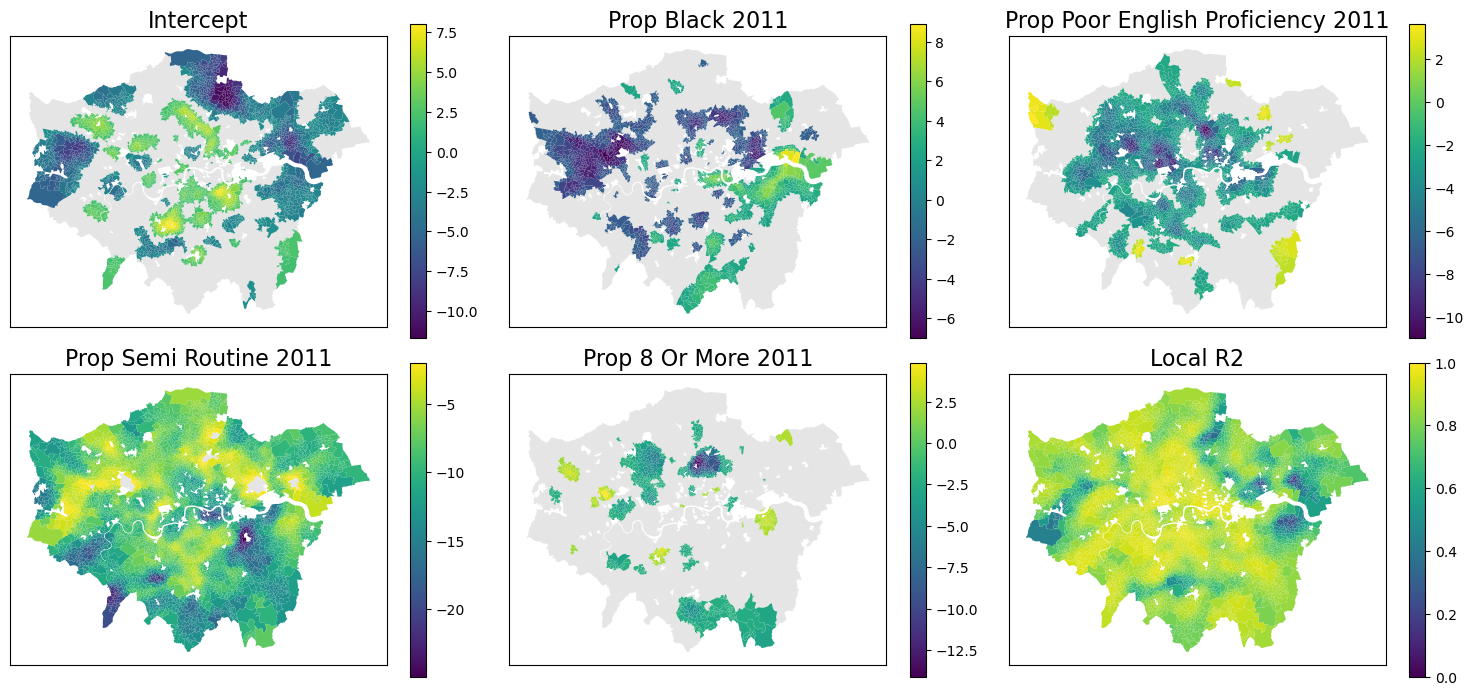

In [45]:
#VISUALISE GWR RESULTS 2011#
f,ax=plt.subplots(2,3,figsize=(15,7), subplot_kw=dict(aspect='equal'))
ax = ax.flatten()
titles = ['Intercept','Prop Black 2011', 'Prop Poor English Proficiency 2011', 'Prop Semi Routine 2011', 'Prop 8 Or More 2011']

for i,row in enumerate(filtered_estimates.T):
    my_df_2011_temp = my_df_2011.assign(toplot=filtered_estimates.T[i])
    (my_df_2011_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    (my_df_2011_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

(my_df_2011.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()

plt.show()

In [46]:
#//////////#

In [47]:
#DATA READING, CLEANING, AND PRE-PROCESSING 2021#

In [48]:
#READ LSOA DATA 2021#
lsoas_2021 = pd.read_csv(os.path.join('Data/LSOAs 2021.csv'))

In [49]:
#READ ENGLISH PROFICIENCY DATA 2021#
english_proficiency_2021 = pd.read_csv(os.path.join('Data/English Proficiency 2021.csv'))

In [50]:
#READ HOUSEHOLD SIZE DATA 2021#
household_size_2021 = pd.read_csv(os.path.join('Data/Household Size 2021.csv'))

In [51]:
#READ NSSEC DATA 2021#
nssec_2021 = pd.read_csv(os.path.join('Data/NSSEC 2021.csv'))

In [52]:
#READ QUALIFICATIONS DATA 2021#
qualifications_2021 = pd.read_csv(os.path.join('Data/Qualifications 2021.csv'))

In [53]:
#CONVERT LSOA DATA 2021 INTO A GEODATAFRAME#
lsoas_2021 = gpd.GeoDataFrame(lsoas_2021)
lsoas_2021['geometry'] = lsoas_2021['geometry'].apply(lambda x: loads(x))
lsoas_2021 = lsoas_2021.set_geometry('geometry')

In [54]:
#CALCUALTE PROPORTION OF BLACK RESIDENTS 2021#
#Wanted to do BAME but had high VIF
lsoas_2021['Prop Black 2021'] = lsoas_2021['Black21'] / lsoas_2021['TotRes21']

In [55]:
#SET THE COLUMNS FOR ENGLISH PROFICIENCY DATA 2021#
cols5 =['LSOA code', 'Usual residents aged 3+', 'Main language is English',
       'Language not English: Speak English very well',
       'Language not English: Speak English well',
       'Language not English: Cannot speak English well',
       'Language not English: Cannot speak English']
english_proficiency_2021_cleaned = english_proficiency_2021[cols5]

In [56]:
#CREATE POOR ENGLISH PROFICIENCY VARIABLE 2021 AND CALCULATE PROPORTION OF POOR ENGLISH PROFICIENCY 2021#
english_proficiency_2021_cleaned['Poor English Proficiency 2021'] = english_proficiency_2021_cleaned['Language not English: Cannot speak English well'] + english_proficiency_2021_cleaned['Language not English: Cannot speak English']
english_proficiency_2021_cleaned['Prop Poor English Proficiency 2021'] = english_proficiency_2021_cleaned['Poor English Proficiency 2021'] / english_proficiency_2021_cleaned['Usual residents aged 3+']

In [57]:
#SET THE COLUMNS FOR HOUSEHOLD SIZE DATA 2021#
cols6 =['LSOA code', 'All Households', '1 person in household', '2 people in household', '3 people in household',
        '4 people in household', '5 people in household', '6 people in household', '7 people in household',
        '8 or more people in household']
household_size_2021_cleaned = household_size_2021[cols6]

In [58]:
#CALCULATE PROPORTION OF 8 OR MORE RESIDENTS 2021#
#Wanted to do more than 5 but had high VIF
household_size_2021_cleaned['Prop 8 Or More 2021'] = household_size_2021_cleaned['8 or more people in household'] / household_size_2021_cleaned['All Households']

In [59]:
#SET THE COLUMNS FOR NSSEC DATA 2021#
cols7 =['LSOA code', 'All usual residents aged 16+', 'Higher managerial admin and professional ',
        'Lower managerial admin and professional ', 'Intermediate ', 'Small employers, own account workers',
        'Lower supervisory and technical ', 'Semi routine', 'Routine ', 'Never worked and long term unemployed',
        'Full time students']
nssec_2021_cleaned = nssec_2021[cols7]

In [60]:
#CALCULATE PROPORTION OF SEMI ROUTINE 2021#
nssec_2021_cleaned['Prop Semi Routine 2021'] = nssec_2021_cleaned['Semi routine'] / nssec_2021_cleaned['All usual residents aged 16+']

In [61]:
#SET THE COLUMNS FOR QUALIFICATIONS DATA 2021#
cols8 =['LSOA code', 'Usual residents aged 16+', 'none', 'Level 1', 'Level 2',
       'Apprentice-ship', 'Level 3', 'Level 4+', 'Other']
qualifications_2021_cleaned = qualifications_2021[cols8]

In [62]:
#CREATE MIN LEVEL 2 VARIABLE 2021 AND CALCULATE PROPORTION OF MIN LEVEL 2 2021#
qualifications_2021_cleaned['Min Level 2 2021'] = qualifications_2021_cleaned['Level 2'] + qualifications_2021_cleaned['Level 3'] + qualifications_2021_cleaned['Level 4+']
qualifications_2021_cleaned['Prop Min Level 2 2021'] = qualifications_2021_cleaned['Min Level 2 2021'] / qualifications_2021_cleaned['Usual residents aged 16+']

In [63]:
#MERGE ALL OF THE 2021 DATAFRAMES TOGETHER#
step_one_2021 = english_proficiency_2021_cleaned.merge(household_size_2021_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')
step_two_2021 = step_one_2021.merge(nssec_2021_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')
step_three_2021 = step_two_2021.merge(qualifications_2021_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')
my_df_2021 = pd.merge(lsoas_2021, step_three_2021, left_on='LSOA21CD', right_on='LSOA code')

In [64]:
#CORRELATION MATRIX 2021#

In [65]:
#DROP IRRELEVANT COLUMNS 2021#
corr_data_2021 = my_df_2021.drop(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM', 
       'All Households', '1 person in household', 'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21', 
       'TotRes11_m21', 'TotHHolds21', '2 people in household', '3 people in household', 'TotHHolds11_m21', 
       'FemRes21', 'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21', 'Black11_m21', 
       'MixedE21', 'MixedE11_m21', 'White21', 'White11_m21', 'OtherE21', 'OtherE11_m21','CarsZero21', 
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21', 'CarsTwo11_m21', 'CarsThrp21', 
       '4 people in household', '5 people in household', '6 people in household','CarsThrp11_m21', 
       'EconEm21', 'EconEm11_m21', 'EconUn21','EconUn11_m21', 'EconSt21', 'EconSt11_m21', 'EconRe21', 
       '7 people in household', 'Higher managerial admin and professional ', 'EconRe11_m21', 'EconOt21', 
       'EconOt11_m21', 'AgeChild21', 'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 
       'Lower managerial admin and professional ', 'AgeSenior21', 'AgeSenior11_m21', 'HealthVG21', 
       'HealthVG11_m21', 'HealthGood21', 'HealthGood11_m21', 'HealthFair21', 'Routine ', 
       'Never worked and long term unemployed', 'Full time students', 'HealthFair11_m21', 'HealthBad21', 
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21', 'QualNone21', 'QualNone11_m21', 'QualSch21',  
       'QualSch11_m21', 'QualUni21', 'QualUni11_m21', 'QualOt21', 'Intermediate ', 'Small employers, own account workers', 
       'Lower supervisory and technical ', 'QualOt11_m21', 'LSOA code', 'Usual residents aged 3+', 
       'Main language is English', 'Language not English: Speak English very well', 'Language not English: Speak English well', 
       'Language not English: Cannot speak English', 'All usual residents aged 16+', 'Language not English: Cannot speak English well',
       'Usual residents aged 16+', 'none', 'Level 1', 'Apprentice-ship', 'Level 2', 'Level 3', 'Level 4+',
       'Other'], axis=1)

In [66]:
#CALCULATE CORRELATION 2021#
corr_2021= corr_data_2021.corr()

In [67]:
#PRESENT CORRELATION 2021#
corr_2021.style.background_gradient(cmap='coolwarm')

,Black21,Prop Black 2021,Poor English Proficiency 2021,Prop Poor English Proficiency 2021,8 or more people in household,Prop 8 Or More 2021,Semi routine,Prop Semi Routine 2021,Min Level 2 2021,Prop Min Level 2 2021
Black21,1.000000,0.961076,0.363566,0.336692,0.178860,0.121217,0.581068,0.528317,-0.020750,-0.371894
Prop Black 2021,0.961076,1.000000,0.278590,0.303678,0.104837,0.073587,0.483297,0.535437,-0.172511,-0.364809
Poor English Proficiency 2021,0.363566,0.278590,1.000000,0.962911,0.623008,0.589849,0.606710,0.445129,-0.046510,-0.577483
Prop Poor English Proficiency 2021,0.336692,0.303678,0.962911,1.000000,0.565166,0.565388,0.525670,0.462320,-0.204883,-0.598034
8 or more people in household,0.178860,0.104837,0.623008,0.565166,1.000000,0.973916,0.400267,0.273303,-0.029816,-0.397787
Prop 8 Or More 2021,0.121217,0.073587,0.589849,0.565388,0.973916,1.000000,0.341020,0.269686,-0.125986,-0.410131
Semi routine,0.581068,0.483297,0.606710,0.525670,0.400267,0.341020,1.000000,0.886683,-0.131708,-0.788600
Prop Semi Routine 2021,0.528317,0.535437,0.445129,0.462320,0.273303,0.269686,0.886683,1.000000,-0.514324,-0.871794
Min Level 2 2021,-0.020750,-0.172511,-0.046510,-0.204883,-0.029816,-0.125986,-0.131708,-0.514324,1.000000,0.586235
Prop Min Level 2 2021,-0.371894,-0.364809,-0.577483,-0.598034,-0.397787,-0.410131,-0.788600,-0.871794,0.586235,1.000000


In [68]:
#VIF 2021#

In [69]:
#SET Y AND X COLUMNS 2021#
y = my_df_2021['Prop Min Level 2 2021']
X = my_df_2021[['Prop Black 2021', 'Prop Poor English Proficiency 2021', 'Prop Semi Routine 2021', 'Prop 8 Or More 2021']]

In [70]:
#FIND VIF 2021#
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,3.614048,Prop Black 2021
1,5.026609,Prop Poor English Proficiency 2021
2,5.809087,Prop Semi Routine 2021
3,2.083917,Prop 8 Or More 2021


In [71]:
#OLS REGRESSION 2021#

In [72]:
#CREATE OLS REGRESSION 2021#
x = ['Prop Black 2021','Prop Poor English Proficiency 2021','Prop Semi Routine 2021','Prop 8 Or More 2021']
X = my_df_2021.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(my_df_2021['Prop Min Level 2 2021'])
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     6130.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:37:02   Log-Likelihood:                 8652.4
No. Observations:                4994   AIC:                        -1.729e+04
Df Residuals:                    4989   BIC:                        -1.726e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [73]:
#GWR MODEL 2021#

In [74]:
#FIND THE CENTERPOINT AND EXTRACT LAT AND LON FROM IT 2021#
my_df_2021['Center_point'] = my_df_2021['geometry'].centroid
my_df_2021["X"] = my_df_2021.Center_point.map(lambda p: p.x)
my_df_2021["Y"] = my_df_2021.Center_point.map(lambda p: p.y)

In [75]:
#PREPARE DATASET INPUTS 2021#
g_y = my_df_2021['Prop Min Level 2 2021'].values.reshape((-1,1))
g_X = my_df_2021[['Prop Black 2021', 'Prop Poor English Proficiency 2021', 'Prop Semi Routine 2021', 'Prop 8 Or More 2021']].values
u = my_df_2021['X']
v = my_df_2021['Y']
g_coords = list(zip(u,v))
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [76]:
#SELECT BANDWIDTH FOR KERNEL 2021#
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y,
                  g_X,
                  fixed=False,
                  spherical=False)

In [77]:
#CALCULATE THE OPTIMUM BANDWIDTH 2021#
bw.search()

80.0

In [78]:
#CALCULATE NEIGHBOURS BASED ON QUEEN'S CONTIGUITY 2021#
wq = Queen.from_dataframe(my_df_2011)
wq

In [79]:
#BUILD THE GEOGRAPHICALLY WEIGHTED REGRESSION MODEL 2021#
model = mgwr.gwr.GWR(g_coords,
                     g_y,
                     g_X,
                     bw.bw[0])

In [80]:
#FIT THE MODEL 2021#
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4994
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            844.342
Log-likelihood:                                                   -2647.924
AIC:                                                               5305.848
AICc:                                                              5307.865
BIC:                                                             -41641.944
R2:                                                                   0.831
Adj. R2:                                                              0.831

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [81]:
#MODEL PERFORMANCE 2021#

In [82]:
#SET PARAMS AND LOCALR2 2021#
data_all = pd.DataFrame(results.params)
localR2=pd.DataFrame(results.localR2)

In [83]:
#CREATE NEW DATAFRAME 2021#
df1=pd.DataFrame(my_df_2021["LSOA21CD"])
df2 = df1.assign(intercept=data_all[0],
                 Prop_Black_2021=data_all[1],
                 Prop_Poor_English_Proficiency_2021=data_all[2],
                 Prop_Semi_Routine_2021=data_all[3],
                 Prop_8_Or_More_2021=data_all[4],
                 
                 localR2=localR2[0])
df2.columns

Index(['LSOA21CD', 'intercept', 'Prop_Black_2021',
       'Prop_Poor_English_Proficiency_2021', 'Prop_Semi_Routine_2021',
       'Prop_8_Or_More_2021', 'localR2'],
      dtype='object')

In [84]:
#VISUALISING 2021#

In [85]:
#FILTER SET OF SIGNIFICANT LOCAL ESTIMATES 2021#
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

In [86]:
#CONVERT ARRAYS TO DATA FRAME 2021#
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [87]:
#CREATE NEW DATAFRAME 2021#
df1=pd.DataFrame(my_df_2021["LSOA21CD"])
results_gdf= df1.assign(intercept=data_params[0],
                 Prop_Black_2021=data_params[1],
                 Prop_Poor_English_Proficiency_2021=data_params[2],
                 Prop_Semi_Routine_2021=data_params[3],
                 Prop_8_Or_More_2021=data_params[4],
                 localR2=data_localR2[0])

In [88]:
#MERGE SHAPEFILE WITH MODEL'S RESULTS 2021#
my_df_2021 = my_df_2021.merge(results_gdf, left_on='LSOA21CD', right_on='LSOA21CD')

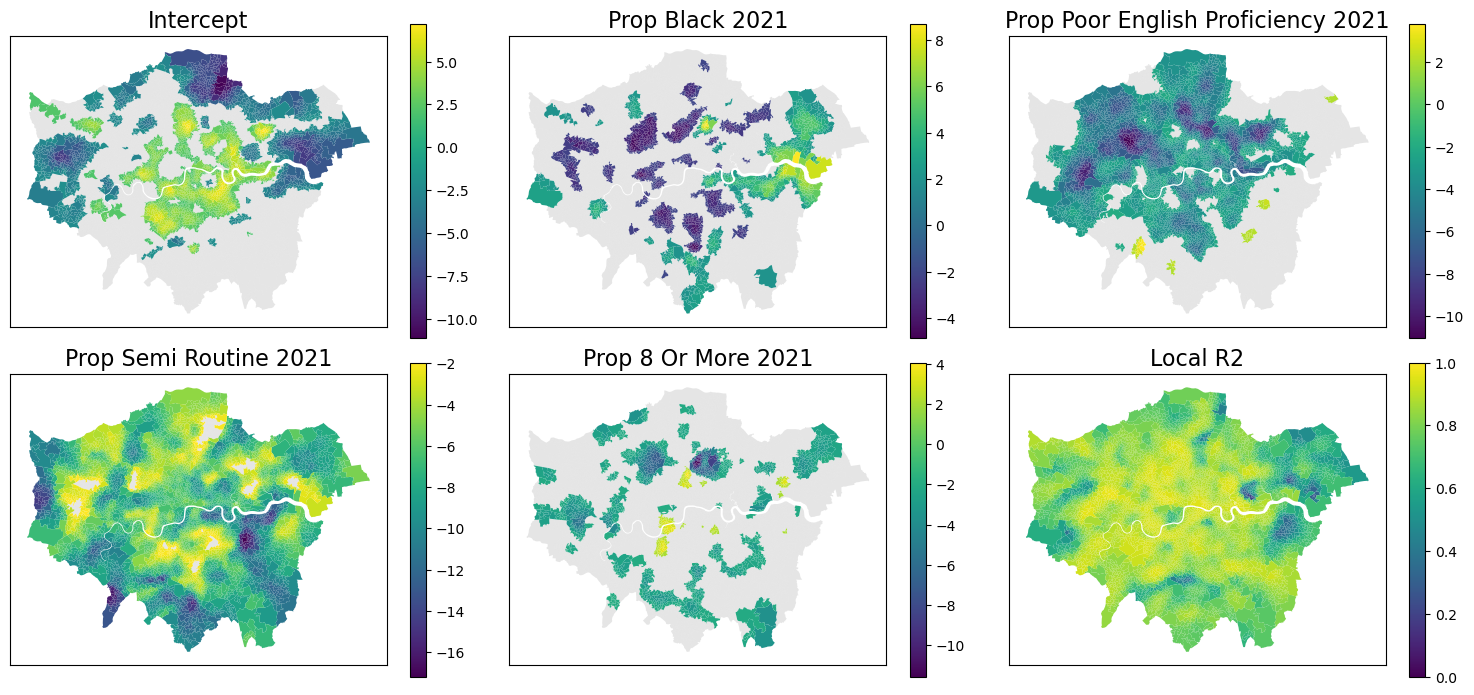

In [89]:
#VISUALISE GWR RESULTS 2021#
f,ax=plt.subplots(2,3,figsize=(15,7), subplot_kw=dict(aspect='equal'))
ax = ax.flatten()
titles = ['Intercept','Prop Black 2021', 'Prop Poor English Proficiency 2021', 'Prop Semi Routine 2021', 'Prop 8 Or More 2021']

for i,row in enumerate(filtered_estimates.T):
    my_df_2021_temp = my_df_2021.assign(toplot=filtered_estimates.T[i])
    (my_df_2021_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    (my_df_2021_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

(my_df_2021.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()

plt.show()